# Tensorflow

TensorFlow is an end-to-end platform for machine learning. It supports the following:

* Multidimensional-array based numeric computation (similar to <a href="https://numpy.org/" class="external">NumPy</a>.)
* GPU and distributed processing
* Automatic differentiation
* Model construction, training, and export
* And more

In [ ]:
!pip install tensorflow

In [5]:
import tensorflow as tf


## Tensors

TensorFlow operates on multidimensional arrays or _tensors_ represented as `tf.Tensor` objects. Here is a two-dimensional tensor:

In [4]:
x = tf.constant([[1., 2., 3.],
                 [4., 5., 6.]])

print(x)
print(x.shape)
print(x.dtype)

tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]], shape=(2, 3), dtype=float32)
(2, 3)
<dtype: 'float32'>


In [6]:
tf.convert_to_tensor([1,2,3])

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 3], dtype=int32)>

In [7]:
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow **IS** using the GPU")
else:
    print("TensorFlow **IS NOT** using the GPU")

TensorFlow **IS NOT** using the GPU


## Variables

Normal `tf.Tensor` objects are immutable. To store model weights (or other mutable state) in TensorFlow use a `tf.Variable`.

In [8]:
var = tf.Variable([0.0, 0.0, 0.0])

In [9]:
var.assign([1, 2, 3])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

In [10]:
var.assign_add([1, 1, 1])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([2., 3., 4.], dtype=float32)>

## Automatic differentiation

<a href="https://en.wikipedia.org/wiki/Gradient_descent" class="external">_Gradient descent_</a> and related algorithms are a cornerstone of modern machine learning.

To enable this, TensorFlow implements automatic differentiation (autodiff), which uses calculus to compute gradients. Typically you'll use this to calculate the gradient of a model's _error_ or _loss_ with respect to its weights.

In [11]:
x = tf.Variable(1.0)

def f(x):
  y = x**2 + 2*x - 5
  return y

In [12]:
f(x)

<tf.Tensor: shape=(), dtype=float32, numpy=-2.0>

In [13]:
with tf.GradientTape() as tape:
  y = f(x)

g_x = tape.gradient(y, x)  # g(x) = dy/dx
g_x

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

## Modules, layers, and models

`tf.Module` is a class for managing your `tf.Variable` objects, and the `tf.function` objects that operate on them. The `tf.Module` class is necessary to support two significant features:

1. You can save and restore the values of your variables using `tf.train.Checkpoint`. This is useful during training as it is quick to save and restore a model's state.
2. You can import and export the `tf.Variable` values _and_ the `tf.function` graphs using `tf.saved_model`. This allows you to run your model independently of the Python program that created it.

Here is a complete example exporting a simple `tf.Module` object:

In [14]:
class MyModule(tf.Module):
  def __init__(self, value):
    self.weight = tf.Variable(value)

  @tf.function
  def multiply(self, x):
    return x * self.weight

In [15]:
mod = MyModule(3)
mod.multiply(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9], dtype=int32)>

In [16]:
save_path = './saved'
tf.saved_model.save(mod, save_path)

INFO:tensorflow:Assets written to: ./saved/assets


In [17]:
reloaded = tf.saved_model.load(save_path)
reloaded.multiply(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9], dtype=int32)>

## Training loops

Now put this all together to build a basic model and train it from scratch.

First, create some example data. This generates a cloud of points that loosely follows a quadratic curve:

In [18]:
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = [9, 6]

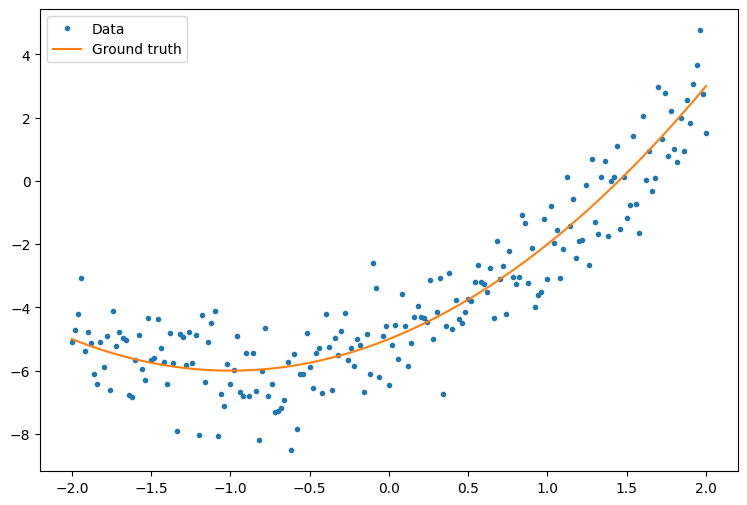

In [19]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)

def f(x):
  y = x**2 + 2*x - 5
  return y

y = f(x) + tf.random.normal(shape=[201])

plt.plot(x.numpy(), y.numpy(), '.', label='Data')
plt.plot(x, f(x), label='Ground truth')
plt.legend();

Create a quadratic model with randomly initialized weights and a bias:

In [20]:
class Model(tf.Module):

  def __init__(self):
    # Randomly generate weight and bias terms
    rand_init = tf.random.uniform(shape=[3], minval=0., maxval=5., seed=22)
    # Initialize model parameters
    self.w_q = tf.Variable(rand_init[0])
    self.w_l = tf.Variable(rand_init[1])
    self.b = tf.Variable(rand_init[2])
  
  @tf.function
  def __call__(self, x):
    # Quadratic Model : quadratic_weight * x^2 + linear_weight * x + bias
    return self.w_q * (x**2) + self.w_l * x + self.b

In [21]:
quad_model = Model()

In [22]:
def plot_preds(x, y, f, model, title):
  plt.figure()
  plt.plot(x, y, '.', label='Data')
  plt.plot(x, f(x), label='Ground truth')
  plt.plot(x, model(x), label='Predictions')
  plt.title(title)
  plt.legend()

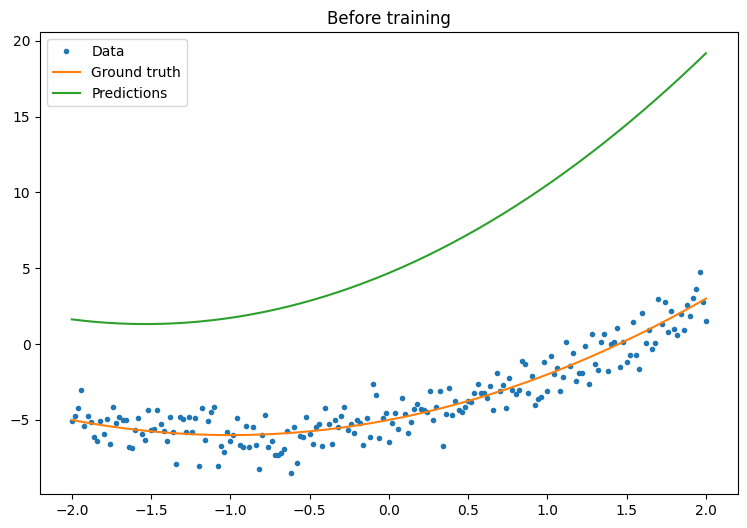

In [23]:
plot_preds(x, y, f, quad_model, 'Before training')

In [26]:
def mse_loss(y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y))

Write a basic training loop for the model. The loop will make use of the MSE loss function and its gradients with respect to the input in order to iteratively update the model's parameters. Using mini-batches for training provides both memory efficiency and faster convergence. The `tf.data.Dataset` API has useful functions for batching and shuffling.

In [24]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=x.shape[0]).batch(batch_size)

Mean squared error for step 0: 58.790
Mean squared error for step 10: 10.000
Mean squared error for step 20: 4.116
Mean squared error for step 30: 2.080
Mean squared error for step 40: 1.371
Mean squared error for step 50: 1.124
Mean squared error for step 60: 1.036
Mean squared error for step 70: 1.007
Mean squared error for step 80: 0.996
Mean squared error for step 90: 0.993




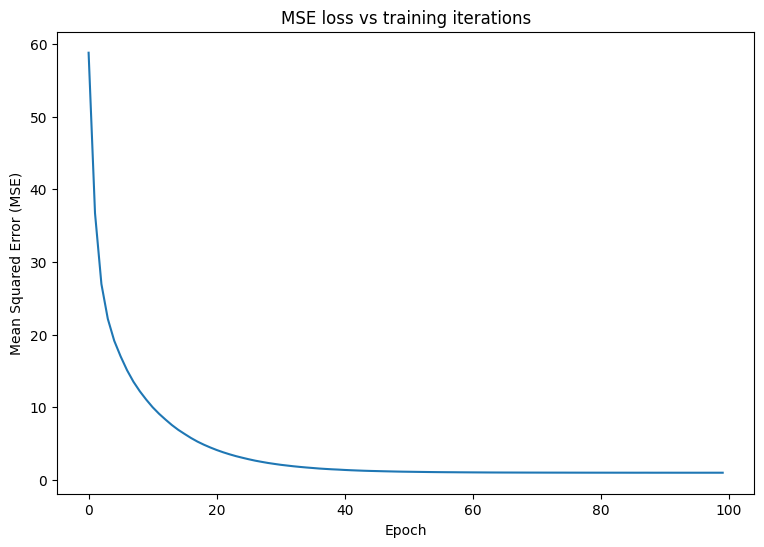

In [27]:
# Set training parameters
epochs = 100
learning_rate = 0.01
losses = []

# Format training loop
for epoch in range(epochs):
  for x_batch, y_batch in dataset:
    with tf.GradientTape() as tape:
      batch_loss = mse_loss(quad_model(x_batch), y_batch)
    # Update parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, quad_model.variables)
    for g,v in zip(grads, quad_model.variables):
        v.assign_sub(learning_rate*g)
  # Keep track of model loss per epoch
  loss = mse_loss(quad_model(x), y)
  losses.append(loss)
  if epoch % 10 == 0:
    print(f'Mean squared error for step {epoch}: {loss.numpy():0.3f}')

# Plot model results
print("\n")
plt.plot(range(epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.title('MSE loss vs training iterations');

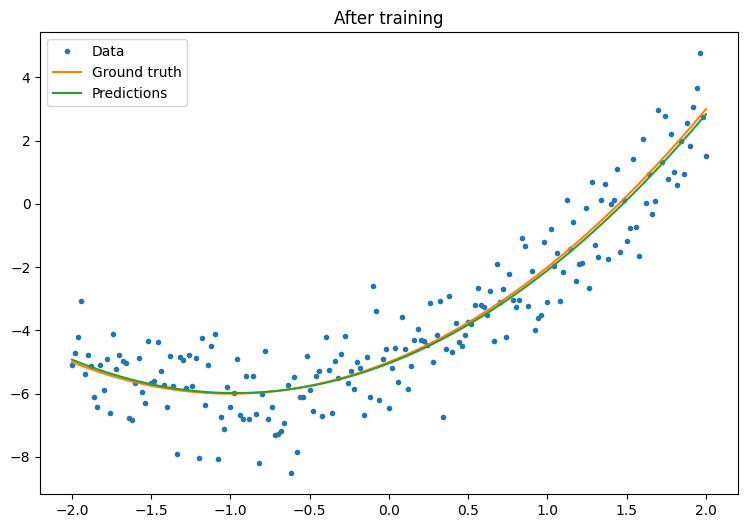

In [28]:
plot_preds(x, y, f, quad_model, 'After training')

That's working, but remember that implementations of common training utilities are available in the `tf.keras` module. So, consider using those before writing your own. To start with, the `Model.compile` and `Model.fit` methods implement a training loop for you:

Begin by creating a Sequential Model in Keras using `tf.keras.Sequential`. One of the simplest Keras layers is the dense layer, which can be instantiated with `tf.keras.layers.Dense`. The dense layer is able to learn multidimensional linear relationships of the form $\mathrm{Y} = \mathrm{W}\mathrm{X} +  \vec{b}$. In order to learn a nonlinear equation of the form, $w_1x^2 + w_2x + b$, the dense layer's input should be a data matrix with $x^2$ and $x$ as features. The lambda layer, `tf.keras.layers.Lambda`, can be used to perform this stacking transformation.

In [29]:
new_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.stack([x, x**2], axis=1)),
    tf.keras.layers.Dense(units=1, kernel_initializer=tf.random.normal)])

In [30]:
new_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01))

history = new_model.fit(x, y,
                        epochs=100,
                        batch_size=32,
                        verbose=0)

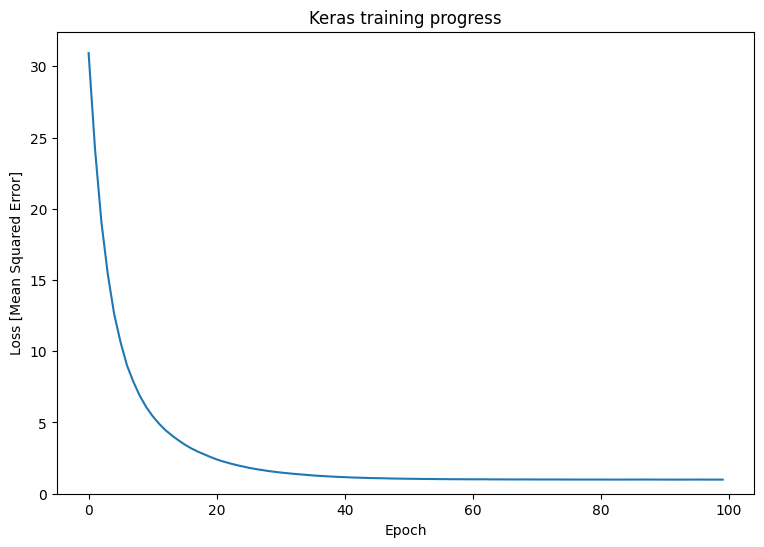

In [31]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Mean Squared Error]')
plt.title('Keras training progress');

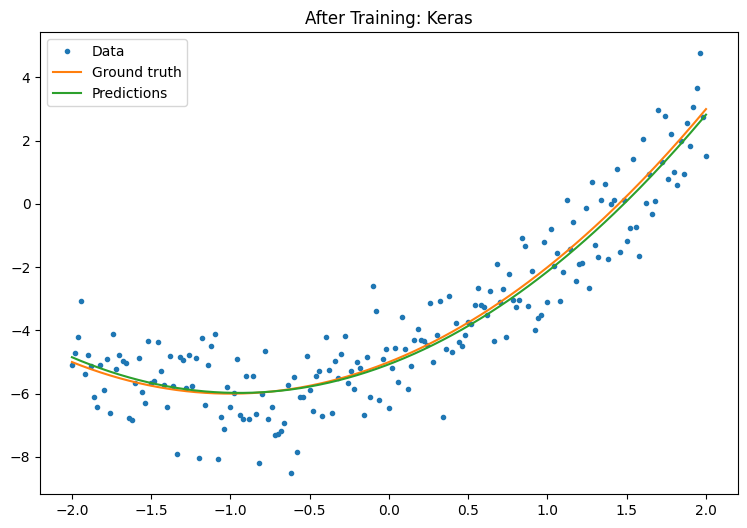

In [32]:
plot_preds(x, y, f, new_model, 'After Training: Keras')

In [ ]:
new_model.save('./my_new_model')